# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

By 
__Juhi Srivastava__ & __Lakshmi Kalyan Sunku__

# Import the Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import os
import datetime
import os

# Image preprocessing Libraries
from skimage import io
from skimage.transform import resize,rescale
from skimage import exposure
from skimage.filters import gaussian



In [2]:
# Keras DL Modules
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout, GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers,regularizers
from keras.regularizers import l1,l2,l1_l2

# Transfer Learning archs
from keras.applications import ResNet50
from keras.applications import MobileNetV2
from keras.applications import MobileNet

import cv2

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [3]:
# set rand_seed as global variable to use it across the assignment
rand_seed = 30

np.random.seed(rand_seed)
import random as rn
rn.seed(rand_seed)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(rand_seed)

import matplotlib.pyplot as plt

# Define Local functions

In [4]:
def metric_comp(hist):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    ax[0].plot(hist.history['categorical_accuracy'])   
    ax[0].plot(hist.history['val_categorical_accuracy'])
    ax[0].legend(['Training Accuracy','Validation Accuracy'])
    ax[0].title.set_text('Model_Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].grid(True)
    
    ax[1].plot(hist.history['loss'])   
    ax[1].plot(hist.history['val_loss'])
    ax[1].legend(['Training Loss','Validation Loss'])
    ax[1].title.set_text('Model_Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].grid(True)

    plt.show()

In [5]:
def brightness(img, low, high):
    value = np.random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list,dims,img_aug=False):
    
    batch_size, num_frms,num_pxs,num_chanls = dims
    print( '\nSource path = ', source_path, '\nbatch size = ', batch_size, '\nNo of Frames = ',num_frms , '\nHeight&Width of Image = ', num_pxs, '\nNo of Channels = ', num_chanls)
    
    # select the number of images randomly without loosing the sequence
    img_idx = np.arange(0,30,(30/num_frms)).astype(int)

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size
        
        scale_factor = 1
        r_num_pxs = num_pxs
        
        
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,len(img_idx),num_pxs,num_pxs,num_chanls)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            if (img_aug):
                batch_data_aug = np.zeros((batch_size,len(img_idx),num_pxs,num_pxs,num_chanls))
                batch_labels_aug = np.zeros((batch_size,5))          
            
            for folder in range(batch_size): # iterate over the batch_size
                
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    img_resize = resize(image,(r_num_pxs,r_num_pxs,3))
                    img_f = rescale(img_resize, (scale_factor,scale_factor,1))
                    
                    batch_data[folder,idx,:,:,0] = (img_f[:,:,0]) / 255
                    batch_data[folder,idx,:,:,1] = (img_f[:,:,1])  / 255
                    batch_data[folder,idx,:,:,2] = (img_f[:,:,2])  / 255
                    
                    #batch_data[folder,idx,:,:,0] = (img_f[:,:,0] - np.percentile(img_f[:,:,0],5)) / (np.percentile(img_f[:,:,0],95) - np.percentile(img_f[:,:,0],5))
                    #batch_data[folder,idx,:,:,1] = (img_f[:,:,1] - np.percentile(img_f[:,:,1],5)) / (np.percentile(img_f[:,:,1],95) - np.percentile(img_f[:,:,1],5))
                    #batch_data[folder,idx,:,:,2] = (img_f[:,:,2] - np.percentile(img_f[:,:,2],5)) / (np.percentile(img_f[:,:,2],95) - np.percentile(img_f[:,:,2],5))
                    
                
                    if (img_aug):
                        #img_a = brightness(image,0.1,2)
                        image_bright = exposure.adjust_gamma(image, gamma=0.25,gain=1)
                        image_dark = exposure.adjust_gamma(image_bright, gamma=2.5,gain=1)
                        img_a = gaussian(image_dark, sigma=5, multichannel=True)
                        
                        img_a_resize = resize(img_a,(r_num_pxs,r_num_pxs,3))
                        img_a_f = rescale(img_a_resize, (scale_factor,scale_factor,1))
                        
                        batch_data_aug[folder,idx,:,:,0] = (img_f[:,:,0]) / 255
                        batch_data_aug[folder,idx,:,:,0] = (img_f[:,:,1]) / 255
                        batch_data_aug[folder,idx,:,:,0] = (img_f[:,:,2]) / 255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            if (img_aug):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])                
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remaining_batch = len(folder_list) % batch_size
        
        batch = num_batches
        batch_data = np.zeros((remaining_batch,len(img_idx),num_pxs,num_pxs,num_chanls))
        batch_labels = np.zeros((remaining_batch,5))
        
        if (img_aug): 
            batch_data_aug = np.zeros((remaining_batch,len(img_idx),num_pxs,num_pxs,num_chanls))
            batch_labels_aug = np.zeros((remaining_batch,5))
        
        for folder in range(remaining_batch):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            
            for idx,item in enumerate(img_idx):
                image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                img_resize = resize(image,(r_num_pxs,r_num_pxs,3))
                img_f = rescale(img_resize, (scale_factor,scale_factor,1))
                
                batch_data[folder,idx,:,:,0] = (img_f[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (img_f[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (img_f[:,:,2])/255
                
                if (img_aug):
                    #img_a = brightness(image,0.1,2)
                    image_bright = exposure.adjust_gamma(image, gamma=0.25,gain=1)
                    image_dark = exposure.adjust_gamma(image_bright, gamma=2.5,gain=1)
                    img_a = gaussian(image_dark, sigma=5, multichannel=True)
                        
                    img_a_resize = resize(img_a,(r_num_pxs,r_num_pxs,3))
                    img_a_f = rescale(img_a_resize, (scale_factor,scale_factor,1))
                        
                    batch_data_aug[folder,idx,:,:,0] = (img_a_f[:,:,0]) / 255
                    batch_data_aug[folder,idx,:,:,0] = (img_a_f[:,:,1]) / 255
                    batch_data_aug[folder,idx,:,:,0] = (img_a_f[:,:,2]) / 255
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
        if (img_aug):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])     
        
        yield batch_data, batch_labels
            
        
        
"""           
        
        r_batch_size = len(folder_list) % batch_size 
        if (r_batch_size != 0):
            
            batch = num_batches
            batch_data = np.zeros((r_batch_size,len(img_idx),num_pxs,num_pxs,num_chanls)) 
            batch_labels = np.zeros((r_batch_size,5)) # batch_labels is the one hot representation of the output
            if (img_aug): 
                batch_data_aug = np.zeros((r_batch_size,len(img_idx),num_pxs,num_pxs,num_chanls))
                batch_labels_aug = np.zeros((r_batch_size,5))   
        
            
            for folder in range(r_batch_size): # iterate over the batch_size 
                imgs = os.listdir(source_path+'/'+ t[folder + (batch * batch_size)].split(';')[0]) # read all the images in the folder
            
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in 
                    image = io.imread(source_path+'/'+ t[folder + (batch * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    img_resize = resize(image,(r_num_pxs,r_num_pxs,3))
                    img_f = rescale(img_resize, (scale_factor,scale_factor,1))
                
                    batch_data[folder,idx,:,:,0] = (img_f[:,:,0])  / 255
                    batch_data[folder,idx,:,:,1] = (img_f[:,:,1]) / 255
                    batch_data[folder,idx,:,:,2] = (img_f[:,:,2])  / 255
                
                    #batch_data[folder,idx,:,:,0] = (img_f[:,:,0] - np.percentile(img_f[:,:,0],5)) / (np.percentile(img_f[:,:,0],95) - np.percentile(img_f[:,:,0],5))
                    #batch_data[folder,idx,:,:,1] = (img_f[:,:,1] - np.percentile(img_f[:,:,1],5)) / (np.percentile(img_f[:,:,1],95) - np.percentile(img_f[:,:,1],5))
                    #batch_data[folder,idx,:,:,2] = (img_f[:,:,2] - np.percentile(img_f[:,:,2],5)) / (np.percentile(img_f[:,:,2],95) - np.percentile(img_f[:,:,2],5))
                
                    if (img_aug):
                        #img_a = brightness(image,0.1,2)
                        image_bright = exposure.adjust_gamma(image, gamma=0.25,gain=1)
                        image_dark = exposure.adjust_gamma(image_bright, gamma=2.5,gain=1)
                        img_a = gaussian(image_dark, sigma=5, multichannel=True)
                        
                        img_a_resize = resize(img_a,(r_num_pxs,r_num_pxs,3))
                        img_a_f = rescale(img_a_resize, (scale_factor,scale_factor,1))
                        
                        batch_data_aug[folder,idx,:,:,0] = (img_f[:,:,0]) / 255
                        batch_data_aug[folder,idx,:,:,0] = (img_f[:,:,1]) / 255
                        batch_data_aug[folder,idx,:,:,0] = (img_f[:,:,2]) / 255
                
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            
            if (img_aug):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])    
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
"""

"           \n        \n        r_batch_size = len(folder_list) % batch_size \n        if (r_batch_size != 0):\n            \n            batch = num_batches\n            batch_data = np.zeros((r_batch_size,len(img_idx),num_pxs,num_pxs,num_chanls)) \n            batch_labels = np.zeros((r_batch_size,5)) # batch_labels is the one hot representation of the output\n            if (img_aug): \n                batch_data_aug = np.zeros((r_batch_size,len(img_idx),num_pxs,num_pxs,num_chanls))\n                batch_labels_aug = np.zeros((r_batch_size,5))   \n        \n            \n            for folder in range(r_batch_size): # iterate over the batch_size \n                imgs = os.listdir(source_path+'/'+ t[folder + (batch * batch_size)].split(';')[0]) # read all the images in the folder\n            \n                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in \n                    image = io.imread(source_path+'/'+ t[folder + (batch 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

# Source the data

In [7]:
# Randomly select the train data and validation data

train_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data//val.csv').readlines())

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


# Different DL Models for Gesture Recognition

## CNN(Conv2d)+RNN - Transfer Learning with GRU

* We have used existing __MobileNet__ for transfer learning
    - No of trainable layers - __ALL__
* It is followed by TimeDistributed, GRU and Dense Layers

In [9]:
# Input dimensions
num_frms = 10
num_pxs = 224
num_chanls = 3

batch_size = 64

# Output dimensions
num_classes = 5

dims = [batch_size,num_frms,num_pxs,num_chanls]

num_epochs = 25
print ('No of epochs =', num_epochs)

No of epochs = 25


In [10]:
input_shape_tl = (num_pxs,num_pxs,num_chanls)

# Initialize the MobileNet model
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape_tl)

trainable = 8

for layer in mobilenet.layers[:-trainable]:
    layer.trainable = False
for layer in mobilenet.layers[-trainable:]:
    layer.trainable = True    

# Initialize the model
model_1 = Sequential()

input_shape = (num_frms,num_pxs,num_pxs,num_chanls)

# Connect the ouput of mobilenet to TimeDistributed layer
model_1.add(TimeDistributed(mobilenet, input_shape=input_shape))
model_1.add(TimeDistributed(Dropout(.2)))
model_1.add(TimeDistributed(BatchNormalization()))
model_1.add(TimeDistributed(GlobalAveragePooling2D()))

# add GRU layer 
model_1.add(GRU(512, activation='relu', return_sequences=False))

# add Dense layer 1
model_1.add(Dense(128, activation='relu'))
model_1.add(BatchNormalization())


# add Dense layer 2
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(.4))

# Ouput layer
model_1.add(Dense(5, activation='softmax'))

# Compile the model
lrate = 0.001
decay = lrate/num_epochs
#optimiser = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False) #write your optimizer
optimiser = optimizers.Adam(lr=1e-3, epsilon = 1e-8, beta_1 = .9, beta_2 = .999)
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

17227776/17225924 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 7, 7, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 7, 7, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 7, 7, 1024)    4096      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 512)               2360832   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_norma

In [11]:
train_generator = generator(train_path, train_doc, dims,img_aug=False)
val_generator = generator(val_path, val_doc, dims,img_aug=False)

In [12]:
model_name = 'model_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1 , patience=3, min_delta=0.000004, mode='auto', verbose=1,min_lr=1e-9)

es = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

callbacks_list = [cp, lr]

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [14]:
model_1_history = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path = 
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train 
batch size = Epoch 1/25
 /mnt/disks/user/project/PROJECT/Project_data/val 
batch size =  64 
No of Frames =  10 
Height&Width of Image =  224 
No of Channels =  3
 64 
No of Frames =  10 
Height&Width of Image =  224 
No of Channels =  3
11/11 [==============================] - 343s 31s/step - loss: 1.3032 - categorical_accuracy: 0.5006 - val_loss: 1.7900 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_1_2020-05-2823_02_42.354278/model-00001-1.34482-0.48718-1.79003-0.46000.h5
Epoch 2/25
11/11 [==============================] - 159s 14s/step - loss: 0.4256 - categorical_accuracy: 0.8506 - val_loss: 1.0301 - val_categorical_accuracy: 0.6900

Epoch 00002: saving model to model_1_2020-05-2823_02_42.354278/model-00002-0.43804-0.84465-1.03012-0.69000.h5
Epoch 3/25
11/11 [==============================] - 156s 14s/step - loss: 0.2346 - categorical_accuracy: 0.9425 - val_loss: 1.0509 - val

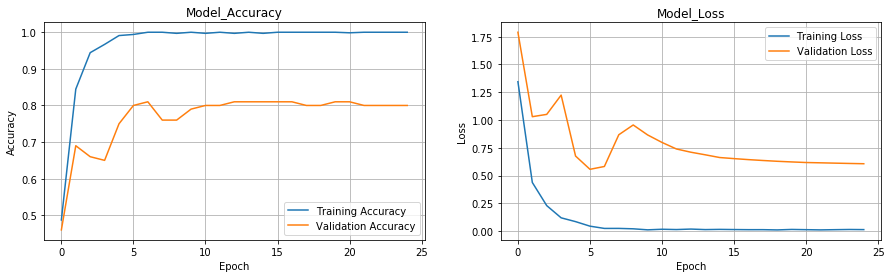

In [15]:
metric_comp(model_1_history)

## CNN(Conv2d)+RNN - Transfer Learning with GRU

* We have used existing __MobileNet__ for transfer learning
    - No of trainable layers - __8__
* It is followed by TimeDistributed, GRU and Dense Layers

In [23]:
# Input dimensions
num_frms = 10
num_pxs = 224
num_chanls = 3

batch_size = 16

# Output dimensions
num_classes = 5

dims = [batch_size,num_frms,num_pxs,num_chanls]

num_epochs = 25
print ('No of epochs =', num_epochs)

No of epochs = 25


In [24]:
input_shape_tl = (num_pxs,num_pxs,num_chanls)

# Initialize the MobileNet model
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape_tl)

trainable = 8

for layer in mobilenet.layers[:-trainable]:
    layer.trainable = False
for layer in mobilenet.layers[-trainable:]:
    layer.trainable = True    

# Initialize the model
model_2 = Sequential()

input_shape = (num_frms,num_pxs,num_pxs,num_chanls)

# Connect the ouput of mobilenet to TimeDistributed layer
model_2.add(TimeDistributed(mobilenet, input_shape=input_shape))
model_2.add(TimeDistributed(Dropout(.2)))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(GlobalAveragePooling2D()))

# add GRU layer 
model_2.add(GRU(512, activation='relu', return_sequences=False))

# add Dense layer 1
model_2.add(Dense(128, activation='relu'))
model_2.add(BatchNormalization())


# add Dense layer 2
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(.4))

# Ouput layer
model_2.add(Dense(5, activation='softmax'))

# Compile the model
lrate = 0.001
decay = lrate/num_epochs
#optimiser = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False) #write your optimizer
optimiser = optimizers.Adam(lr=1e-3, epsilon = 1e-8, beta_1 = .9, beta_2 = .999)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 10, 7, 7, 1024)    3228864   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 7, 7, 1024)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 10, 7, 7, 1024)    4096      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 10, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 512)               2360832   
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
__________

In [25]:
train_generator = generator(train_path, train_doc, dims,img_aug=True)
val_generator = generator(val_path, val_doc, dims,img_aug=False)

In [26]:
model_name = 'model_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1 , patience=3, min_delta=0.000004, mode='auto', verbose=1,min_lr=1e-9)

es = EarlyStopping( monitor='val_loss', patience=5, verbose=1)

callbacks_list = [cp, lr]

In [27]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [28]:
model_2_history = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /mnt/disks/user/project/PROJECT/Project_data/val
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train  
batch size = 
batch size =  16 
No of Frames =  10 
Height&Width of Image =  224 
No of Channels =  3
Epoch 1/25
 16 
No of Frames =  10 
Height&Width of Image =  224 
No of Channels =  3
42/42 [==============================] - 399s 9s/step - loss: 1.1773 - categorical_accuracy: 0.5394 - val_loss: 1.3387 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_2_2020-05-2905_53_38.876432/model-00001-1.17475-0.53997-1.33869-0.50000.h5
Epoch 2/25
42/42 [==============================] - 377s 9s/step - loss: 0.4936 - categorical_accuracy: 0.8080 - val_loss: 1.5720 - val_categorical_accuracy: 0.4800

Epoch 00002: saving model to model_2_2020-05-2905_53_38.876432/model-00002-0.48641-0.80920-1.57201-0.48000.h5
Epoch 3/25
42/42 [==============================] - 375s 9s/step - loss: 0.2864 - categorical_accuracy: 0.9053 - val_loss: 2.4601 - val_ca

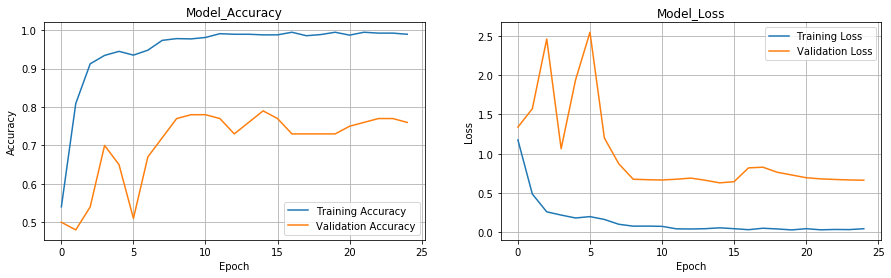

In [29]:
metric_comp(model_2_history)

## CNN(Conv2d)+RNN - Transfer Learning with LSTM

* We have used existing __MobileNet__ for transfer learning
    - No of trainable layers - __ALL__
* It is followed by TimeDistributed, GRU and Dense Layers

In [30]:
# Input dimensions
num_frms = 10
num_pxs = 224
num_chanls = 3

batch_size = 64

# Output dimensions
num_classes = 5

dims = [batch_size,num_frms,num_pxs,num_chanls]

num_epochs = 25
print ('No of epochs =', num_epochs)

No of epochs = 25


In [31]:
input_shape_tl = (num_pxs,num_pxs,num_chanls)

# Initialize the MobileNet model
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape_tl)

trainable = 8

for layer in mobilenet.layers[:-trainable]:
    layer.trainable = False
for layer in mobilenet.layers[-trainable:]:
    layer.trainable = True    

# Initialize the model
model_3 = Sequential()

input_shape = (num_frms,num_pxs,num_pxs,num_chanls)

# Connect the ouput of mobilenet to TimeDistributed layer
model_3.add(TimeDistributed(mobilenet, input_shape=input_shape))
model_3.add(TimeDistributed(Dropout(.2)))
model_3.add(TimeDistributed(BatchNormalization()))
model_3.add(TimeDistributed(GlobalAveragePooling2D()))

# add GRU layer 
model_3.add(LSTM(512, activation='relu', return_sequences=False))

# add Dense layer 1
model_3.add(Dense(128, activation='relu'))
model_3.add(BatchNormalization())


# add Dense layer 2
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(.4))

# Ouput layer
model_3.add(Dense(5, activation='softmax'))

# Compile the model
lrate = 0.001
decay = lrate/num_epochs
#optimiser = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False) #write your optimizer
optimiser = optimizers.Adam(lr=1e-3, epsilon = 1e-8, beta_1 = .9, beta_2 = .999)
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 10, 7, 7, 1024)    3228864   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 10, 7, 7, 1024)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 7, 7, 1024)    4096      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 10, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               3147776   
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

In [32]:
train_generator = generator(train_path, train_doc, dims,img_aug=False)
val_generator = generator(val_path, val_doc, dims,img_aug=False)

In [33]:
model_name = 'model_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1 , patience=3, min_delta=0.000004, mode='auto', verbose=1,min_lr=1e-9)

es = EarlyStopping( monitor='val_loss', patience=8, verbose=1)

callbacks_list = [cp, lr]

In [34]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [35]:
model_3_history = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /mnt/disks/user/project/PROJECT/Project_data/val 
batch size =  64 
No of Frames =  10 
Height&Width of Image =  224 
No of Channels =  3

Source path =  /mnt/disks/user/project/PROJECT/Project_data/train 
batch size =  64 
No of Frames =  10 
Height&Width of Image =  224 
No of Channels =  3
Epoch 1/25
11/11 [==============================] - 177s 16s/step - loss: 1.2903 - categorical_accuracy: 0.5078 - val_loss: 2.4463 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_3_2020-05-2905_53_38.876432/model-00001-1.27120-0.51433-2.44627-0.46000.h5
Epoch 2/25
11/11 [==============================] - 139s 13s/step - loss: 0.5073 - categorical_accuracy: 0.8137 - val_loss: 1.4237 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_3_2020-05-2905_53_38.876432/model-00002-0.51188-0.81297-1.42367-0.57000.h5
Epoch 3/25
11/11 [==============================] - 135s 12s/step - loss: 0.2624 - categorical_accuracy: 0.9245 - val_loss: 0.9063 - val

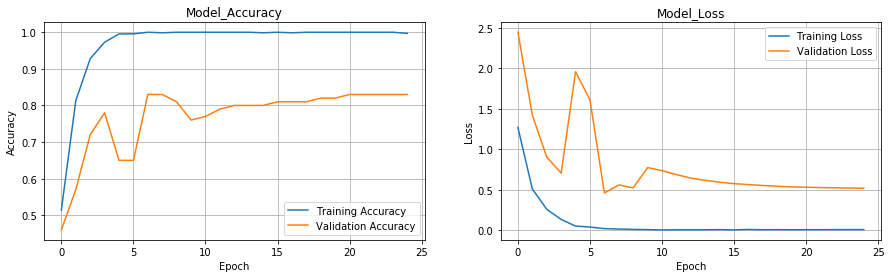

In [36]:
metric_comp(model_3_history)

## CNN(Conv3d) Base Model

In [37]:
# Input dimensions
num_frms = 15
num_pxs = 100
num_chanls = 3

batch_size = 64

# Output dimensions
num_classes = 5

dims = [batch_size,num_frms,num_pxs,num_chanls]

num_epochs = 25
print ('No of epochs =', num_epochs)

No of epochs = 25


In [38]:
# model
model_4 = Sequential()

input_shape = (num_frms,num_pxs,num_pxs,num_chanls) # input shape = (num_frms, img_rows, img_cols, num_chnls)

# first conv3d layer
model_4.add(Conv3D(16, kernel_size=(2,2,2),padding='same',
                 activation='relu',input_shape=input_shape))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2,2,2)))

# second conv3d layer
model_4.add(Conv3D(32, kernel_size=(2,2,2),padding='same',
                 activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2,2,2)))

# third conv3d layer
model_4.add(Conv3D(64, kernel_size=(2,2,2),padding='same',
                 activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2,2,2)))


# Flatten the layers
model_4.add(Flatten())

# Dense layer 
model_4.add(Dense(128,activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.4))

# Dense layer (good64)
model_4.add(Dense(128,activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.45))

# softmax layer
model_4.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimiser = optimizers.Adam(lr=0.0001)
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_4.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 50, 50, 32)     4128      
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 50, 50, 32)     128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 25, 25, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 25, 25, 64)     16448     
__________

In [39]:
train_generator = generator(train_path, train_doc, dims,img_aug=False)
val_generator = generator(val_path, val_doc, dims,img_aug=False)

In [40]:
model_name = 'model_4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1 , patience=3, min_delta=0.000004, mode='auto', verbose=1,min_lr=1e-9)

es = EarlyStopping( monitor='val_loss', patience=6, verbose=1)

callbacks_list = [cp, lr]

In [41]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [42]:
model_4_history = model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /mnt/disks/user/project/PROJECT/Project_data/val
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train 
batch size =  64 
No of Frames =  15 
Height&Width of Image =  100 
No of Channels =  3
Epoch 1/25
 
batch size =  64 
No of Frames =  15 
Height&Width of Image =  100 
No of Channels =  3
11/11 [==============================] - 240s 22s/step - loss: 2.1934 - categorical_accuracy: 0.2732 - val_loss: 1.5676 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_4_2020-05-2905_53_38.876432/model-00001-2.22654-0.27149-1.56760-0.35000.h5
Epoch 2/25
11/11 [==============================] - 114s 10s/step - loss: 1.6335 - categorical_accuracy: 0.4164 - val_loss: 1.3191 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_4_2020-05-2905_53_38.876432/model-00002-1.63118-0.41780-1.31908-0.43000.h5
Epoch 3/25
11/11 [==============================] - 132s 12s/step - loss: 1.3065 - categorical_accuracy: 0.4974 - val_loss: 1.1802 - val

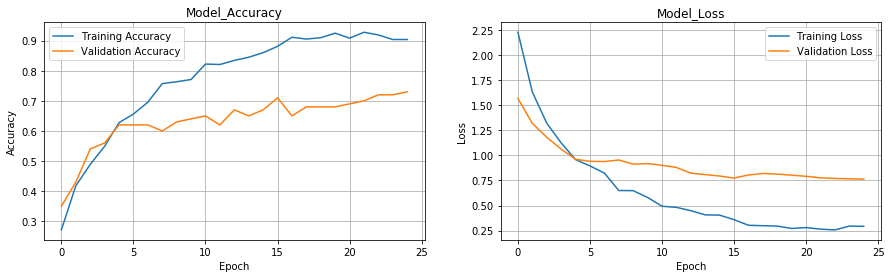

In [43]:
metric_comp(model_4_history)

## CNN(Conv3d) with Image Augumentation

In [9]:
# Input dimensions
num_frms = 15
num_pxs = 80
num_chanls = 3

batch_size = 32  # Since we have augumentation, we have reduced the batch size to fit the data into memory

# Output dimensions
num_classes = 5

dims = [batch_size,num_frms,num_pxs,num_chanls]

num_epochs = 25
print ('No of epochs =', num_epochs)

No of epochs = 25


In [10]:
# model
model_5 = Sequential()

input_shape = (num_frms,num_pxs,num_pxs,num_chanls) # input shape = (num_frms, img_rows, img_cols, num_chnls)

# first conv3d layer
model_5.add(Conv3D(16, kernel_size=(2,2,2),padding='same',
                 activation='relu',input_shape=input_shape))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2,2,2)))

# second conv3d layer
model_5.add(Conv3D(32, kernel_size=(2,2,2),padding='same',
                 activation='relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2,2,2)))

# third conv3d layer
model_5.add(Conv3D(128, kernel_size=(2,2,2),padding='same',
                 activation='relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2,2,2)))


# Flatten the layers
model_5.add(Flatten())

# Dense layer 
model_5.add(Dense(128,activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.4))

# Dense layer (good64)
model_5.add(Dense(256,activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.45))

# softmax layer
model_5.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimiser = optimizers.Adam(lr=0.0001)
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_5.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 80, 80, 16)    400       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 40, 40, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 40, 40, 32)     4128      
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 40, 40, 32)     128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 20, 20, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 20, 20, 128)    32896     
__________

In [11]:
train_generator = generator(train_path, train_doc, dims,img_aug=True)
val_generator = generator(val_path, val_doc, dims,img_aug=False)

In [12]:
model_name = 'model_5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1 , patience=2, min_delta=0.000004, mode='auto', verbose=1,min_lr=1e-9)

es = EarlyStopping( monitor='val_loss', patience=4, verbose=1)

callbacks_list = [cp, lr]

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [14]:
model_5_history = model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /mnt/disks/user/project/PROJECT/Project_data/val 
batch size =  32 
No of Frames =  15 
Height&Width of Image =  80 
No of Channels =  3
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train 
batch size =  32 
No of Frames =  15 
Height&Width of Image =  80 
No of Channels =  3

Epoch 1/25
21/21 [==============================] - 529s 25s/step - loss: 2.1143 - categorical_accuracy: 0.3023 - val_loss: 1.4129 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model_5_2020-05-2915_26_47.780794/model-00001-2.10990-0.30317-1.41294-0.48000.h5
Epoch 2/25
21/21 [==============================] - 377s 18s/step - loss: 1.5319 - categorical_accuracy: 0.4438 - val_loss: 1.0119 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_5_2020-05-2915_26_47.780794/model-00002-1.52221-0.44646-1.01195-0.58000.h5
Epoch 3/25
21/21 [==============================] - 339s 16s/step - loss: 1.3685 - categorical_accuracy: 0.5122 - val_loss: 1.0211 - val_c

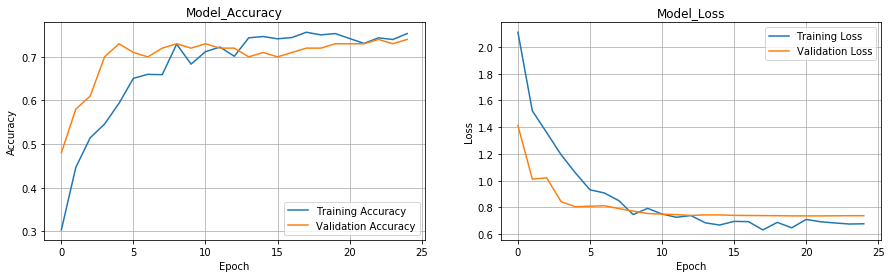

In [15]:
metric_comp(model_5_history)

## CNN(Conv3d) reduce the no of frames and pixes with higher batch size

In [9]:
# Input dimensions
num_frms = 10
num_pxs = 80
num_chanls = 3

batch_size = 64

# Output dimensions
num_classes = 5

dims = [batch_size,num_frms,num_pxs,num_chanls]

num_epochs = 25
print ('No of epochs =', num_epochs)

No of epochs = 25


In [10]:
# model
model_6 = Sequential()

input_shape = (num_frms,num_pxs,num_pxs,num_chanls) # input shape = (num_frms, img_rows, img_cols, num_chnls)

# first conv3d layer
model_6.add(Conv3D(16, kernel_size=(2,2,2),padding='same',
                 activation='relu',input_shape=input_shape))
model_6.add(BatchNormalization())
model_6.add(MaxPooling3D(pool_size=(2,2,2)))

# second conv3d layer
model_6.add(Conv3D(32, kernel_size=(2,2,2),padding='same',
                 activation='relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling3D(pool_size=(2,2,2)))

# third conv3d layer
model_6.add(Conv3D(64, kernel_size=(2,2,2),padding='same',
                 activation='relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling3D(pool_size=(2,2,2)))


# Flatten the layers
model_6.add(Flatten())

# Dense layer 
model_6.add(Dense(128,activation='relu'))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.4))

# Dense layer (good64)
model_6.add(Dense(128,activation='relu'))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.45))

# softmax layer
model_6.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimiser = optimizers.Adam(lr=0.0001)
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_6.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 10, 80, 80, 16)    400       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 40, 40, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 40, 40, 32)     4128      
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 40, 40, 32)     128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 20, 20, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 20, 20, 64)     16448     
__________

In [11]:
train_generator = generator(train_path, train_doc, dims,img_aug=False)
val_generator = generator(val_path, val_doc, dims,img_aug=False)

In [12]:
model_name = 'model_6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1 , patience=3, min_delta=0.000004, mode='auto', verbose=1,min_lr=1e-9)

es = EarlyStopping( monitor='val_loss', patience=6, verbose=1)

callbacks_list = [cp, lr]

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [14]:
model_6_history = model_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /mnt/disks/user/project/PROJECT/Project_data/val 
batch size =  64 
No of Frames =  10 
Height&Width of Image =  80 
No of Channels =  3

Source path =  /mnt/disks/user/project/PROJECT/Project_data/train 
batch size =  Epoch 1/25
64 
No of Frames =  10 
Height&Width of Image =  80 
No of Channels =  3
11/11 [==============================] - 217s 20s/step - loss: 2.4244 - categorical_accuracy: 0.2181 - val_loss: 1.6693 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_6_2020-05-2911_45_04.639424/model-00001-2.46332-0.21569-1.66925-0.26000.h5
Epoch 2/25
11/11 [==============================] - 93s 8s/step - loss: 1.8706 - categorical_accuracy: 0.3321 - val_loss: 1.5083 - val_categorical_accuracy: 0.3500

Epoch 00002: saving model to model_6_2020-05-2911_45_04.639424/model-00002-1.88909-0.32881-1.50835-0.35000.h5
Epoch 3/25
11/11 [==============================] - 71s 6s/step - loss: 1.6062 - categorical_accuracy: 0.4278 - val_loss: 1.3539 - val_categ

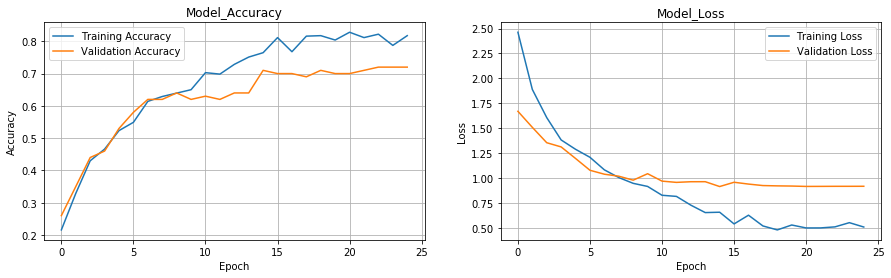

In [15]:
metric_comp(model_6_history)

## CNN(Conv3d) Increase the no of layers

In [16]:
# Input dimensions
num_frms = 16
num_pxs = 100
num_chanls = 3

batch_size = 64

# Output dimensions
num_classes = 5

dims = [batch_size,num_frms,num_pxs,num_chanls]

num_epochs = 25
print ('No of epochs =', num_epochs)

No of epochs = 25


In [17]:
# model
model_7 = Sequential()

input_shape = (num_frms,num_pxs,num_pxs,num_chanls) # input shape = (num_frms, img_rows, img_cols, num_chnls)

# first conv3d layer
model_7.add(Conv3D(16, kernel_size=(2,2,2),padding='same',
                 activation='relu',input_shape=input_shape))
model_7.add(BatchNormalization())
model_7.add(MaxPooling3D(pool_size=(2,2,2)))

# second conv3d layer
model_7.add(Conv3D(32, kernel_size=(2,2,2),padding='same',
                 activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling3D(pool_size=(2,2,2)))

# third conv3d layer
model_7.add(Conv3D(64, kernel_size=(2,2,2),padding='same',
                 activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling3D(pool_size=(2,2,2)))

model_7.add(Conv3D(128, kernel_size=(2,2,2),padding='same',
                 activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling3D(pool_size=(2,2,2)))


# Flatten the layers
model_7.add(Flatten())

# Dense layer 
model_7.add(Dense(128,activation='relu'))
model_7.add(BatchNormalization())
model_7.add(Dropout(0.4))

# Dense layer (good64)
model_7.add(Dense(128,activation='relu'))
model_7.add(BatchNormalization())
model_7.add(Dropout(0.45))

# softmax layer
model_7.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimiser = optimizers.Adam(lr=0.0001)
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_7.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 50, 50, 32)     128       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 4, 25, 25, 32)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 4, 25, 25, 64)     16448     
__________

In [18]:
train_generator = generator(train_path, train_doc, dims,img_aug=False)
val_generator = generator(val_path, val_doc, dims,img_aug=False)

In [19]:
model_name = 'model_7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1 , patience=3, min_delta=0.000004, mode='auto', verbose=1,min_lr=1e-9)

es = EarlyStopping( monitor='val_loss', patience=6, verbose=1)

callbacks_list = [cp, lr]

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
model_7_history = model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /mnt/disks/user/project/PROJECT/Project_data/val 
batch size =  64 
No of Frames =  16 
Height&Width of Image =  100 
No of Channels =  3

Source path =  /mnt/disks/user/project/PROJECT/Project_data/train 
batch size =  64 
No of Frames =  16 
Height&Width of Image =  100 
No of Channels =  3
Epoch 1/25
11/11 [==============================] - 244s 22s/step - loss: 2.2742 - categorical_accuracy: 0.2950 - val_loss: 1.5944 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to model_7_2020-05-2911_45_04.639424/model-00001-2.28681-0.28959-1.59443-0.38000.h5
Epoch 2/25
11/11 [==============================] - 133s 12s/step - loss: 1.8810 - categorical_accuracy: 0.3636 - val_loss: 1.4160 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_7_2020-05-2911_45_04.639424/model-00002-1.87541-0.36199-1.41599-0.44000.h5
Epoch 3/25
11/11 [==============================] - 116s 11s/step - loss: 1.5502 - categorical_accuracy: 0.4649 - val_loss: 1.1875 - val

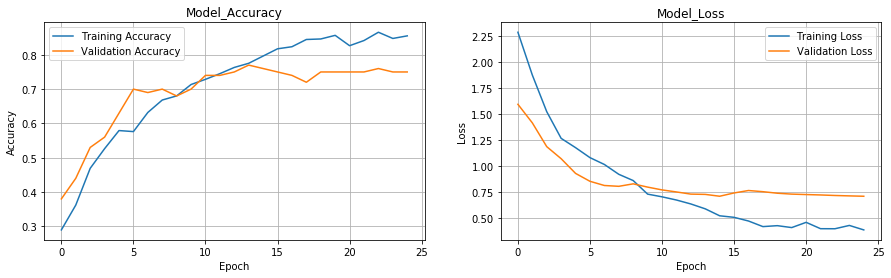

In [22]:
metric_comp(model_7_history)

## CNN(Conv3d) 

In [30]:
# Input dimensions
num_frms = 8
num_pxs = 80
num_chanls = 3

batch_size = 128

# Output dimensions
num_classes = 5

dims = [batch_size,num_frms,num_pxs,num_chanls]

num_epochs = 25
print ('No of epochs =', num_epochs)

No of epochs = 25


In [31]:
# model
model_8 = Sequential()

input_shape = (num_frms,num_pxs,num_pxs,num_chanls) # input shape = (num_frms, img_rows, img_cols, num_chnls)

# first conv3d layer
model_8.add(Conv3D(16, kernel_size=(2,2,2),padding='same',
                 activation='relu',input_shape=input_shape))
model_8.add(BatchNormalization())
model_8.add(MaxPooling3D(pool_size=(2,2,2)))

# second conv3d layer
model_8.add(Conv3D(32, kernel_size=(2,2,2),padding='same',
                 activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling3D(pool_size=(2,2,2)))

# third conv3d layer
model_8.add(Conv3D(64, kernel_size=(2,2,2),padding='same',
                 activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten the layers
model_8.add(Flatten())

# Dense layer 
model_8.add(Dense(128,activation='relu'))
model_8.add(BatchNormalization())
model_8.add(Dropout(0.4))

# Dense layer (good64)
model_8.add(Dense(128,activation='relu'))
model_8.add(BatchNormalization())
model_8.add(Dropout(0.45))

# softmax layer
model_8.add(Dense(num_classes, activation='softmax'))

# Compile the model
optimiser = optimizers.Adam(lr=0.0001)
model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model_8.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 8, 80, 80, 16)     400       
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 80, 80, 16)     64        
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 4, 40, 40, 16)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 4, 40, 40, 32)     4128      
_________________________________________________________________
batch_normalization_17 (Batc (None, 4, 40, 40, 32)     128       
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 2, 20, 20, 32)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 2, 20, 20, 64)     16448     
__________

In [32]:
train_generator = generator(train_path, train_doc, dims,img_aug=False)
val_generator = generator(val_path, val_doc, dims,img_aug=False)

In [33]:
model_name = 'model_8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1 , patience=3, min_delta=0.000004, mode='auto', verbose=1,min_lr=1e-9)

es = EarlyStopping( monitor='val_loss', patience=6, verbose=1)

callbacks_list = [cp, lr]

In [34]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [35]:
model_8_history = model_8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /mnt/disks/user/project/PROJECT/Project_data/val 
batch size =  128 
No of Frames =  8 
Height&Width of Image =  80 
No of Channels =  3

Source path =  /mnt/disks/user/project/PROJECT/Project_data/train 
batch size =  128 
No of Frames =  8 
Height&Width of Image =  80 
No of Channels =  3
Epoch 1/25
6/6 [==============================] - 83s 14s/step - loss: 2.5636 - categorical_accuracy: 0.1946 - val_loss: 1.7528 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_8_2020-05-2915_26_47.780794/model-00001-2.58172-0.19155-1.75283-0.27000.h5
Epoch 2/25
6/6 [==============================] - 74s 12s/step - loss: 2.0948 - categorical_accuracy: 0.3197 - val_loss: 1.4268 - val_categorical_accuracy: 0.4500

Epoch 00002: saving model to model_8_2020-05-2915_26_47.780794/model-00002-2.04757-0.33333-1.42675-0.45000.h5
Epoch 3/25
6/6 [==============================] - 51s 9s/step - loss: 1.6368 - categorical_accuracy: 0.4211 - val_loss: 1.2877 - val_categorical

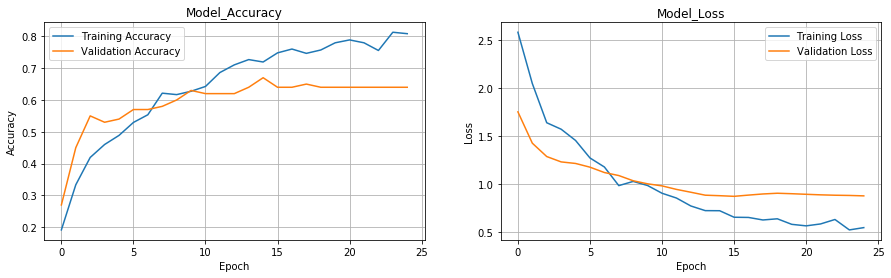

In [36]:
metric_comp(model_8_history)